<a href="https://colab.research.google.com/github/20bken/Jodrell-Bank-Observatory/blob/main/Searching_for_Pulsars_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fourier Transforming Pulsar Data from Lovell Telescope

### Import Data

This first cell mounts the memory space that stores all the files we need to extract data about each pulsar measured by the Lovell Telescope. There are two types of files for each pulsar, a header file, and the raw data file. The header contains info on when the readings were taken, what the sampling time was, what the total observation time (integration time) was among other things.

One of the headers, titled Freq1, gives information on the frequency our recevier was tuned to measure from the sky. 1.42 GHz is typically used to find the galactic hydrogen as it gives a strong signal to noise ratio that mathces the hydrogen line frequency. For pulsars, trying to measure frequencies around 0.61 GHz is better since there is more signal-to-noise ratio to capture from the pulsars although the signal will be fainter. There will also be signal broadening due to extinction from the interstellar medium.

In [ ]:
# To begin, we import some libraries that we will need later.

# Some handy standard python libraries
import os

# The numpy library will allow us to do FFTs
import numpy as np

# The pyplot module from matplotlib will allow us to plot things.
from  matplotlib import pyplot as plt

import math

# pi is a useful value!
from math import pi

# In order to mark the peaks of the signal
from scipy import signal

# In order to fit a curve
from scipy.optimize import curve_fit


# Connect (mount) your google drive as a virtual directory accessible by this python code.
from google.colab import drive         # Import the python module that allows you to access your google drive
rootpathdrive = '/content/drive'       # This will be the directory as which your google drive will be known
drive.mount(rootpathdrive)             # Now connect to this google drive.

# At first use it will ask you to click on a link, after which you should give permission
# for outside processes to access your google drive. A authorization code is generated which should be entered
#(this is explained in https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd).

# A good test to do is if you can see the contents of the directory in which you work on your google drive.
# Here "My Drive" refers to the "root" of your google drive.
# By default your notebook should be in a directory called Colab Notebooks.
# This template assumes all files you want to read in are copied in the
# same directory. Note the slash at the end of the first line.
pathcrabtemplate = rootpathdrive+'/'+'My Drive/University of Manchester/Year 3/Crab Pulsar Lab Experiment JBO/Crab_pulsar_template/'
filelist = []
for (dirpath, dirnames, filenames) in os.walk(pathcrabtemplate):
    filelist.extend(filenames)
    break
print (filelist)   # Show the contents of your working directory. At least your notebook should show up here.

# Defining the path to the data files...
data_directory=os.path.join(pathcrabtemplate,'LovellTimeSeries/')

print("Files avaliable:",os.listdir(data_directory))

# this is the file we will work on. Change this to select the observation you want to process.
myfile = "psr0.dat"
hdrfile= "psr0.hdr"

Mounted at /content/drive
['README.md', 'template.txt', 'Crab Pulsar Timing.ipynb', '.gitignore', 'LICENSE', 'Dedispersion and data visualisation.ipynb', 'Make Time of Arrivals.ipynb', 'Searching for Pulsars 1.ipynb', 'Searching for Pulsars 3.ipynb', 'Searching for Pulsars 4 (From original template).ipynb', 'Searching for Pulsars 5.ipynb', 'Searching for Pulsars 0.ipynb', 'Searching for Pulsars 2.ipynb', 'Crab Pulsars Lab graphs .gslides']
Files avaliable: ['psr0.dat', 'psr3.dat', 'psr4.hdr', 'psr2.dat', 'psr5.dat', 'psr2.hdr', 'psr1.dat', 'psr3.hdr', 'psr0.hdr', 'psr1.hdr', 'psr4.dat', 'psr5.hdr']


### Graph Raw Data

Once the pulsar data files become available, we can start getting useful information out of it. One such useful information is figuring out what the amplitude as a function of time looks like for the pulsars. This is an easy way to visualise all the useful and useless noise the telescope received while hunting for pulsars.

The useful noise would be the signal of the pulsar itself while the useless noise is the surrounding signals obscuring the pulsar's pulse signature.

Date 02/11/04
MJD  52582
UT   10:53:04
Freq1 1427.5
Tsamp 10.0000000

Tsamp = 0.01 seconds
Total observation time is 327.68 seconds


Text(0.5, 1.0, 'Noise plus hidden signal of psr0.dat')

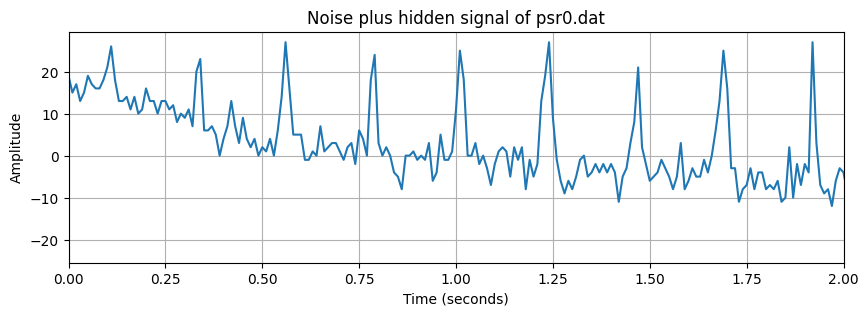

In [ ]:
useful_list = []

# Read the header file.
with open(os.path.join(data_directory,hdrfile)) as f:
    for line in f:
        line=line.strip()
        print(line)
        line=line.split(" ")
        useful_list.append(line[-1])

# Parse the header and get the values you need. The header value we want, sampling time (s), is in useful_list[4].
    sampling_time = float(useful_list[4])*1e-3

        # In this demo code we just read the header and print it to the screen
        # You need to implement code to parse the header and get the values you need.
print("Tsamp = {} seconds".format(sampling_time))

fname = data_directory+"/{}".format(myfile)
raw_bytes = np.fromfile(fname, dtype="byte")

npts = len(raw_bytes)
t = np.linspace(0,(npts-1)*sampling_time,npts)

# We can plot the data.
print("Total observation time is {} seconds".format(npts*sampling_time))
plt.figure(figsize=(10,3))
plt.plot(t,raw_bytes)
plt.xlim(0,2)
plt.grid()
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Noise plus hidden signal of {}".format(myfile))

### FFT Raw data

In order to find the useful signal amidst the background noise, we apply the Fast Fourier Transform (FFT) which converts all the signals into peaks of different height of power as a fucntion of frequency which corresponds to how periodic their noise was. A sharp peak of descending order per frequency interval shows the harmonics of the signal and can be used to calculate the width of the pulsar signal in amplitude-time form.

44.1436767578125


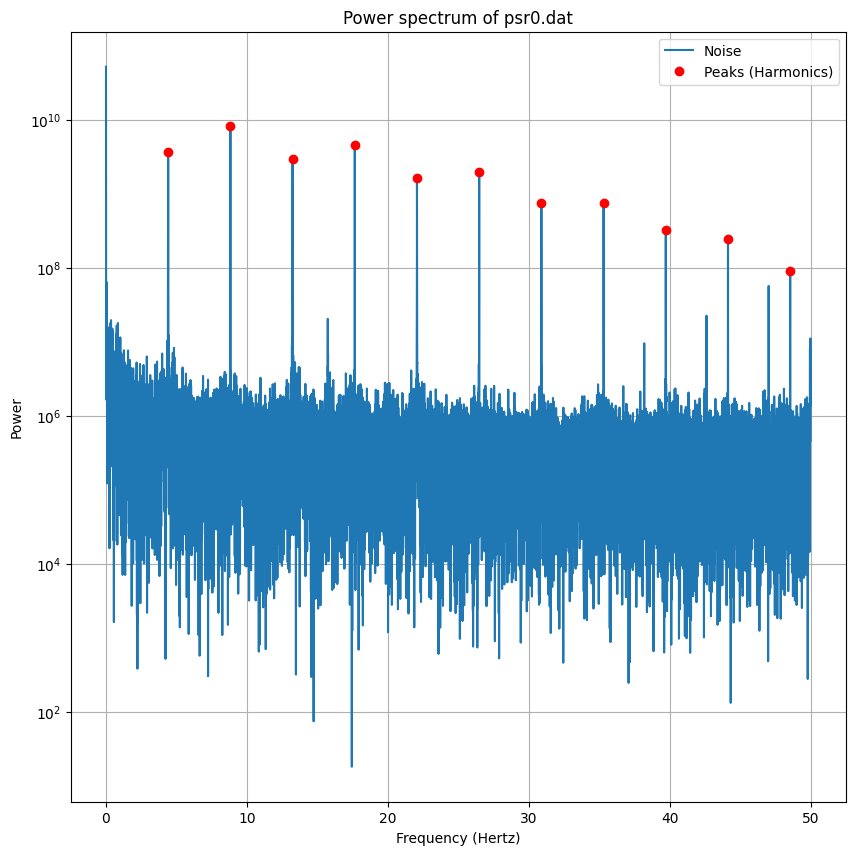

In [ ]:
ft = np.fft.rfft(raw_bytes)

# The Fourier transform of a real-valued sequence sill creates complex values. Here we just take the "power spectrum".
# Note that the real() function from numpy operates on the entire array of numbers, and the multiply and add operators
# act over the entire array, summing elementwise.
power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)
frequency = np.fft.rfftfreq(len(raw_bytes), sampling_time)

# Find peaks in the power spectrum
peaks, _ = signal.find_peaks(np.log(power), height=18, distance = 1, prominence = 10)  # Adjust the threshold (height) as needed

plt.figure(figsize=(10,10))
plt.plot(frequency, power, label='Noise')
plt.yscale("log")  # Set the y-axis to a logarithmic scale

# Highlight the peaks with red dots
plt.plot(frequency[peaks], power[peaks], "ro", label='Peaks (Harmonics)')

print(frequency[peaks[9]])

pulse_period = 1/((frequency[peaks[8]])/9)


plt.xlabel("Frequency (Hertz)")
plt.ylabel("Power")
plt.title("Power spectrum of {}".format(myfile))
plt.legend()
plt.grid()
plt.show()

https://www.me.psu.edu/cimbala/me345web_Fall_2014/Lectures/Fourier_Transforms_DFTs_FFTs.pdf  This is FTT theory


### Filtering out anomalies

As seem from the graph above, the red dots identify the peaks. The problem is that some of the peaks are outliers casued by background noise likely coming from the Mains power supply frequency emission. We filter out the anomalies by using scipy functions like signal.find_peaks wit np.delete. The peaks with red dots are valid while ht eones without red dots are the peaks we care about.

[]
4.412841796875


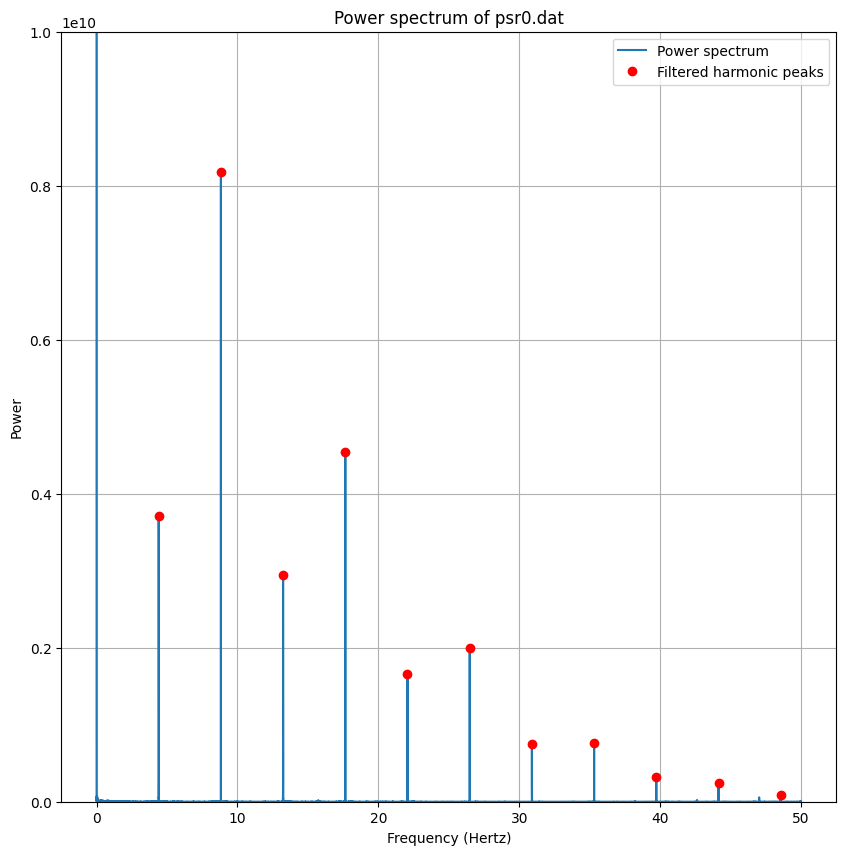

In [ ]:
# Your existing code
ft = np.fft.rfft(raw_bytes)
power = np.real(ft) * np.real(ft) + np.imag(ft) * np.imag(ft)
frequency = np.fft.rfftfreq(len(raw_bytes), sampling_time)
peaks, _ = signal.find_peaks(np.log(power), height=18, distance = 1, prominence = 10)
peaks_right = np.delete(np.insert(peaks, 0, 0), len(peaks))
peaks_left = np.delete(np.append(peaks, 0), 0)

# Set the power between Hertz to 0
# frequency_min = 47  # Minimum frequency to set to 0
# frequency_max = 52  # Maximum frequency to set to 0
# power[(frequency >= frequency_min) & (frequency <= frequency_max)] = 0
threshold = 1000000000000000
width = 10

# Filter peaks to exclude those within the specified frequency range
#filtered_peaks = [peak for peak in peaks if frequency[peak] < frequency_min or frequency[peak] > frequency_max]
peaks_to_remove = peaks[(abs(power[peaks] - power[peaks_right]) > threshold) & (abs(power[peaks] - power[peaks_left]) > threshold)]
print(peaks_to_remove)
power[peaks_to_remove] = 0
filtered_peaks = [peak for peak in peaks if peak not in peaks_to_remove]

# Plot the modified power spectrum
plt.figure(figsize=(10, 10))
plt.plot(frequency, power, label='Power spectrum')

# Highlight the filtered peaks with red dots
plt.plot(frequency[filtered_peaks], power[filtered_peaks], "ro", label='Filtered harmonic peaks')

print(frequency[filtered_peaks[0]])

filtered_pulse_period = 1 / (frequency[filtered_peaks[10]] / 11)
filtered_pulse_width = filtered_pulse_period/(2*9)

plt.xlabel("Frequency (Hertz)")
plt.ylabel("Power")
plt.title("Power spectrum of {}".format(myfile))
#plt.text(10, 100000000, "Period: {:.2f} seconds".format(filtered_pulse_period))
#plt.xlim(0, 40)
plt.ylim(0, 10000000000)
plt.legend()
plt.grid()
plt.show()


### Graphing the Power spectrum without the outliers using filter from previous section

This is redundant for Pulsar 0 becuase there is nothing to filter out cause the peaks matched up nicely

48.5565185546875


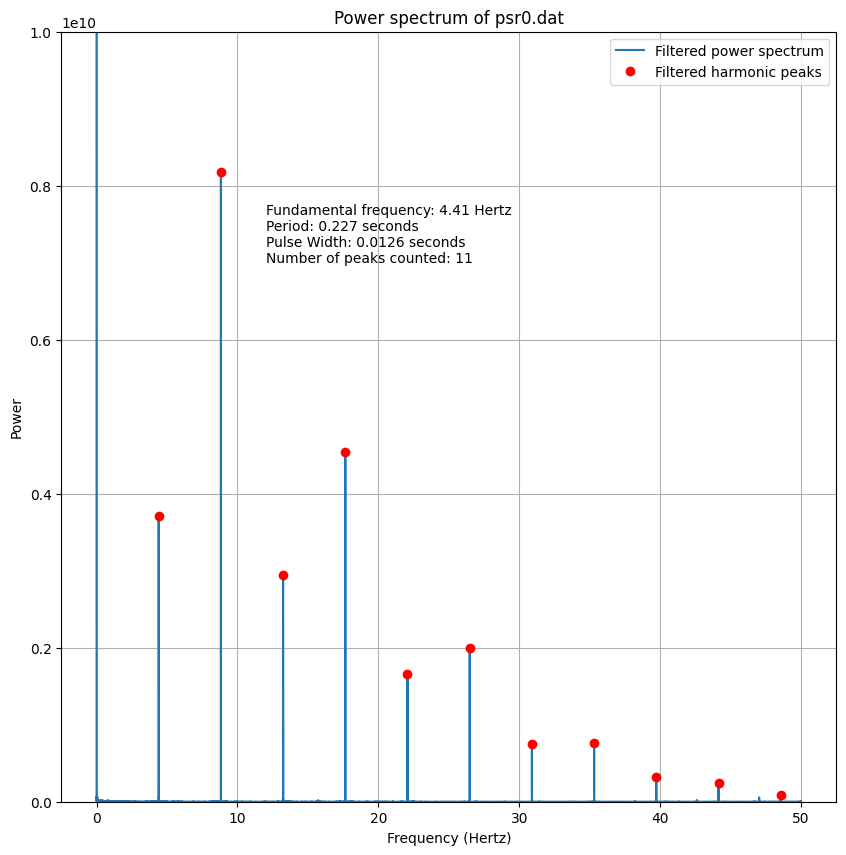

In [ ]:
# Set the power between Hertz to 0
frequency_min = 555  # Minimum frequency to set to 0
frequency_max = 5555  # Maximum frequency to set to 0
power[(frequency >= frequency_min) & (frequency <= frequency_max)] = 0

# Filter peaks to exclude those within the specified frequency range
filtered_peaks = [peak for peak in peaks if frequency[peak] < frequency_min or frequency[peak] > frequency_max]

# Plot the modified power spectrum
plt.figure(figsize=(10, 10))
plt.plot(frequency, power, label='Filtered power spectrum')

# Highlight the filtered peaks with red dots
plt.plot(frequency[filtered_peaks], power[filtered_peaks], "ro", label='Filtered harmonic peaks')

# PLottig a Sinc function over the existing data
#plt.plot(frequency, y, label='Fitted sinc function')
print(frequency[filtered_peaks[10]])


plt.xlabel("Frequency (Hertz)")
plt.ylabel("Power")
plt.title("Power spectrum of {}".format(myfile))
plt.text(12, 7000000000, "Fundamental frequency: {:.2f} Hertz\nPeriod: {:.3f} seconds\nPulse Width: {:.4f} seconds \nNumber of peaks counted: {} ".format(1/filtered_pulse_period, filtered_pulse_period, filtered_pulse_width, 11))
#plt.xlim(0, 20)
plt.ylim(0, 10000000000)
plt.legend()
plt.grid()
plt.show()


Code such that:

First function FFTs the data: Completed

Second function finds peaks from FFT: Completed

Third function filters the anomalies out: Ongoing

Fourth function plots the results

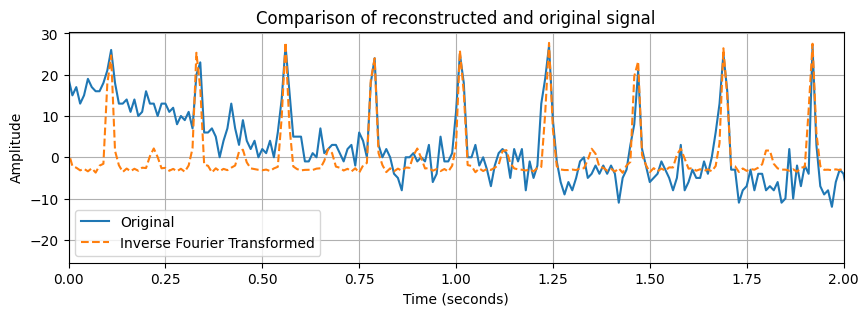

In [ ]:
# Create a new array representing the Fourier transform of the filtered peaks
filtered_ft = np.zeros_like(ft)
filtered_ft[filtered_peaks] = ft[filtered_peaks]

# Perform inverse Fourier transform
filtered_signal = np.fft.irfft(np.sqrt(np.real(filtered_ft)**2+np.imag(filtered_ft)**2))

# Create a time axis for the amplitude-time graph
filtered_t = np.linspace(0, (len(filtered_signal) - 1) * sampling_time, len(filtered_signal))

# Plot the amplitude-time graph
plt.figure(figsize=(10, 3))
plt.plot(t,raw_bytes,  label = "Original")
plt.plot(filtered_t-0.12, filtered_signal, linestyle='dashed', label = "Inverse Fourier Transformed")
plt.legend()
plt.grid()
plt.xlim(0,2)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Comparison of reconstructed and original signal")
plt.show()


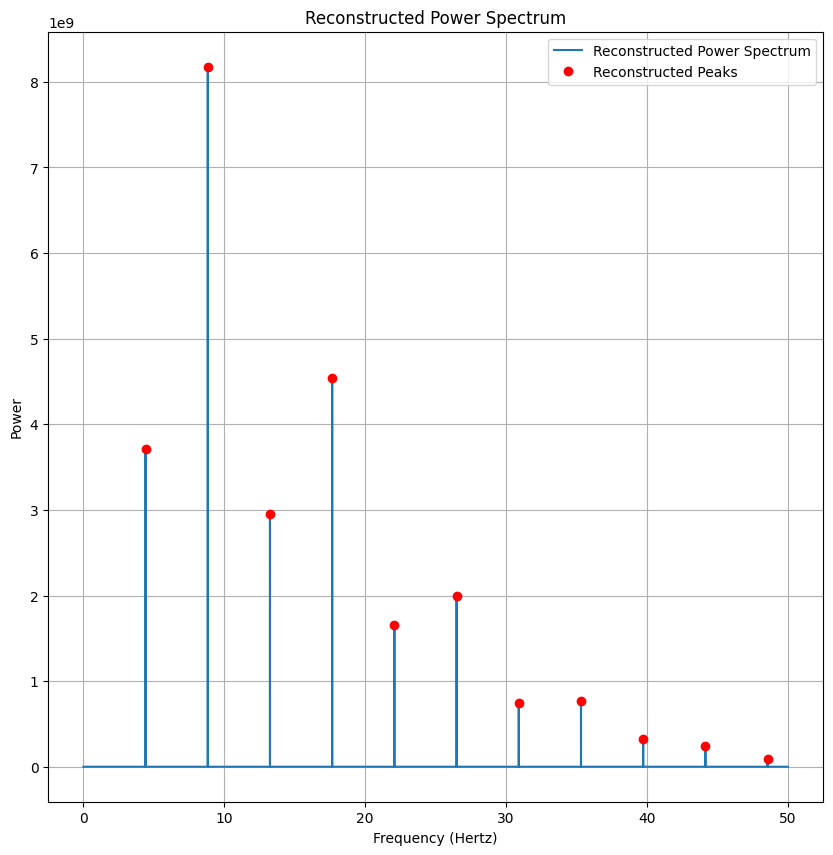

In [ ]:
# Perform a second inverse Fourier transform to reconstruct the signal
reconstructed_signal = np.fft.irfft(np.fft.rfft(filtered_signal))

# Plot the power spectrum of the reconstructed signal
reconstructed_ft = np.fft.rfft(reconstructed_signal)
reconstructed_power = np.real(reconstructed_ft) * np.real(reconstructed_ft) + np.imag(reconstructed_ft) * np.imag(reconstructed_ft)
reconstructed_frequency = np.fft.rfftfreq(len(reconstructed_signal), sampling_time)

# Find peaks in the power spectrum of the reconstructed signal
reconstructed_peaks, _ = signal.find_peaks(np.log(reconstructed_power), height=18, distance = 1, prominence = 10)

# Plot the power spectrum of the reconstructed signal
plt.figure(figsize=(10, 10))
plt.plot(reconstructed_frequency, reconstructed_power, label='Reconstructed Power Spectrum')
plt.plot(reconstructed_frequency[reconstructed_peaks], reconstructed_power[reconstructed_peaks], "ro", label='Reconstructed Peaks')
plt.xlabel("Frequency (Hertz)")
plt.ylabel("Power")
plt.title("Reconstructed Power Spectrum")
plt.legend()
plt.grid()
plt.show()
